In [1]:
from orange_peels import OrangePeelsDataset
from orange_peels import Constants as c
import utils
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import random

# Image Pre-processing
With PyTorch's `transforms` module, we perform the necessary pre-processing steps.
- `Resize`: resizes the image
- `Normalize`: normalizes the image to match the ResNet50 mean and standard deviation

In [2]:
transform = transforms.Compose([
    transforms.Resize((int(c.IMG_SIZE[0]*c.IMG_MAG), int(c.IMG_SIZE[1]*c.IMG_MAG))),
    transforms.Normalize(mean=c.RESNET_MEAN, std=c.RESNET_STD)
])

inv_transform = transforms.Compose([
    transforms.Normalize(mean = [0., 0., 0.,], std = [1/sd for sd in c.RESNET_STD]),
    transforms.Normalize(mean = [-m for m in c.RESNET_MEAN], std = [1., 1., 1.]),
])

# Loading the Data
We load the data such that each class is represented equally.

In [3]:
# data = OrangePeelsDataset(c.IMG_DIR, class_size=91, transform=transform, stats=True) # 91 is the max. class size for the 6 years class
data = OrangePeelsDataset("./data_orange_peels_split/", class_size=2063, transform=transform, stats=True)

Class: 10	Available: 2571		Added: 2063
Class: 15	Available: 2690		Added: 2063
Class: 20	Available: 2755		Added: 2063
Class: 6	Available: 2063		Added: 2063
		Total: 10079		Total: 8252


We can randomly select an image and display it to see how it looks.

**NOTE:** We apply an inverse transform first to view the image before normalization.

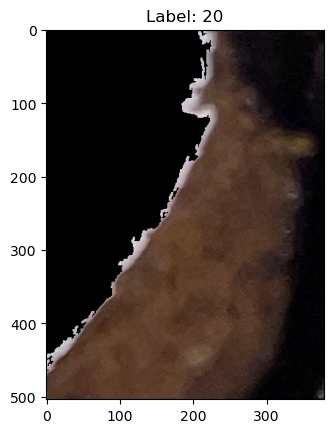

Shape: torch.Size([3, 504, 378]) (1)


In [4]:
img = data[random.randint(0, len(data))]
utils.view_image(inv_transform(img[0]), img[1], c.DECODER)
print(f"Shape: {img[0].shape} ({c.IMG_MAG})")

We also set `device` to be the GPU.

In [5]:
device = utils.get_device()

Device: cuda:0


# Training the Model
We select a base model to start from (e.g., ResNet50).

In [6]:
# load resnet50
model_name = "resnet50" 
base = torch.hub.load("pytorch/vision:v0.13.1", model_name, weights="ResNet50_Weights.DEFAULT")

Using cache found in C:\Users\fongc/.cache\torch\hub\pytorch_vision_v0.13.1


We use `sklearn`'s `KFold` object to split the dataset into five folds. Alternatively, **stratified *k*-fold** could be used for a balanced class representation.

In [7]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_idx, test_idx) in enumerate(skf.split(data.annotations["image_path"], data.annotations["label"])):
    train_loader, test_loader = utils.create_loader(data, train_idx=train_idx, test_idx=test_idx)
    optimizer = torch.optim.Adam
    model, optimizer = utils.create_model(base, optimizer, output_layers=2048, remove_layers=1, device=device)
    # model, optimizer = utils.create_model_inception(base, optimizer, device=device) # for Inception V3 only
    criterion = nn.CrossEntropyLoss()
    train_loss, train_acc, test_acc = utils.train_model(model, train_loader, test_loader, optimizer, criterion, device=device, stats=True)
    pred, true = utils.test_model(model, test_loader, device=device, save=True)
    utils.results_to_json(f"{model_name}_{i}.json", train_loss, train_acc, test_acc, pred, true)

Training...
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo


KeyboardInterrupt: 